In [1]:
import argparse
import logging
import math
import os
import random
from collections import namedtuple
from typing import Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import tqdm
import time

import diffrax
import equinox as eqx
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
from jax import grad, jit, vmap, value_and_grad
import optax

from jax.experimental import stax
from jax.experimental.stax import (BatchNorm, Conv, Dense, Flatten, Relu, Tanh,LogSoftmax)
#from jax.experimental import optimizers
from jax.example_libraries import optimizers

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [2]:
# output values from 0 to maxval with iters steps
class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1,iters)
        self._val = maxval/self._iters
        self._maxval = maxval
    
    def step(self):
        self._val = min(self._maxval, self._val+self._maxval/self._iters)
        
    @property
    def val(self):
        return self._val

In [3]:
class EMAMetric(object):
    def __init__(self, gamma: Optional[float]=0.99):
        super(EMAMetric, self).__init__()
        self._val=None
        self._gamma = gamma
    def step(self, x):
        if self._val is None:
            self._val = x
        else:
            self._val = self._gamma * self._val + (1-self._gamma)*x
        return self._val
    
    @property
    def val(self):
        return self._val

In [4]:
# make sure that the dvision is stable
def _stable_division(a,b,epsilon=1e-7):
    b = jnp.where(jnp.absolute(b)> epsilon, b, jnp.full_like(b, fill_value=epsilon)*jnp.sign(b))
    return a/b

In [5]:

batch_size = 100

## 5. Simulation of time series

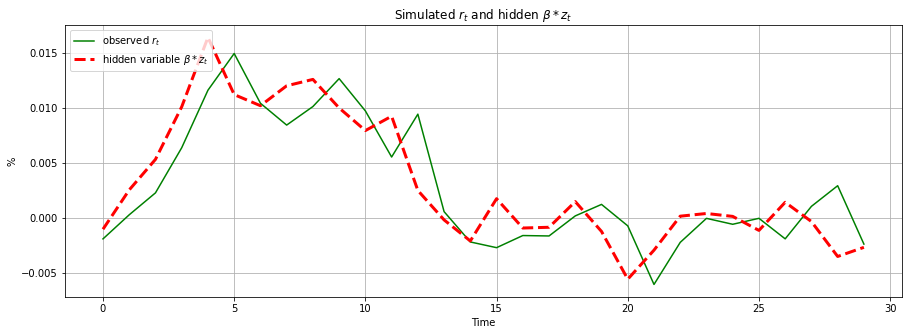

In [6]:
T = 30
#beta = 0.1694
beta=1
def make_time_series():
    
    
    phi = 0.99
    sigma_v = 0.003342
    sigma_u = 0.00328
    rho = -0.856
    cov_uv = rho * sigma_u * sigma_v

    # generating shocks
    mu = [0,0]
    cov = [[sigma_u**2, cov_uv], [cov_uv, sigma_v**2]]
    shocks = np.random.multivariate_normal(mu, cov, T)

    z0 = np.random.normal(0, sigma_u**2/(1-phi**2),1)
    r0 = shocks[0][0]

    z = np.zeros(T)
    r = np.zeros(T)
    z[0] = z0
    r[0] = r0

    for idx_t in range(T-1):
        z[idx_t+1] = phi*z[idx_t] + shocks[idx_t+1][1]
        r[idx_t+1] = beta*z[idx_t+1] + shocks[idx_t+1][0]
    return z, r
z, r = make_time_series()
plt.figure(figsize=(15,5))
xvalues = np.array(range(T))
plt.plot(xvalues, r, linestyle='-', color='g', label="observed $r_t$")
plt.plot(xvalues, z, linestyle="--", color="r", label=r"hidden variable $\beta * z_t$", linewidth=3.0)

plt.legend(loc="upper left")
plt.xlabel('Time')
plt.ylabel('%')
plt.grid(True)
plt.title(r"Simulated $r_t$ and hidden $\beta * z_t$")
plt.show()

In [7]:
@jit
def make_data():
    ts_ = jnp.linspace(0.1,30.0,30)
    ts_ext_ = jnp.array([0.] + list(ts_) + [30.1])
    ts_vis_ = jnp.linspace(0.1, 30.0, 30)
    ys_ = jnp.array(r[:,None])
    return ts_, ts_ext_, ts_vis_, ys_

In [8]:
theta = 1.0
mu = 0.
sigma = 0.001
key = jrandom.PRNGKey(1)
logvar = jnp.log(sigma**2/(2.*theta))

py0_mean = jnp.array([[mu]])
py0_std = jnp.array([[sigma]])
qy0_mean = jnp.array([[mu]])
qy0_logvar = jnp.array([[logvar]])

init_net, net = stax.serial(Dense(200),Tanh,
                           Dense(200),Tanh,
                           Dense(1))
_,net_params = init_net(key,(batch_size,3))
params = [qy0_mean,qy0_logvar] + net_params




def get_std(logvar):
    return jnp.exp(.5 * logvar)

@jit
def loss(params,ts,ys,key):
    zs, kl = forward(ts,batch_size,params,key)
    zs = jnp.squeeze(zs)
    zs = zs[1:-1] 
    logpy = jax.scipy.stats.norm.logpdf(ys,loc=zs,scale=0.0001).sum(axis=0).mean(axis=0)
    loss = -logpy + kl * kl_scheduler.val
    return loss

def forward(ts, batch_size,params,key):
    def f(t, y,args):
        t = jnp.full_like(y, t)
        return net(params[2:],jnp.concatenate((jnp.sin(t),jnp.cos(t),y),axis=-1))

    def g(t, y,args):  # Shared diffusion.
        return jnp.ones((jnp.size(y,0),1))*sigma

    def h(t, y,args):  # Prior drift.
        return theta * (mu - y)

    def f_aug(t, y,args):  # Drift for augmented dynamics with logqp term.
        y = y[:, 0:1] # 提取第一列，保持列的形态
        fv, gv, hv = f(t, y,args), g(t, y,args), h(t, y,args)
        u = _stable_division(fv - hv, gv) # 计算u(z,t)
        f_logqp = .5 * (u ** 2).sum(axis=1, keepdims=True) # 计算integral
        return jnp.concatenate([fv, f_logqp], axis=1)

    def g_aug(t, y,args):  # Diffusion for augmented dynamics with logqp term.
        y = y[:, 0:1]
        gv = g(t, y,args)
        g_logqp = jnp.zeros_like(y)
        return jnp.concatenate([gv, g_logqp], axis=1)
    t0 = ts[0]
    t1 = ts[-1]
    dt0 = 0.01
    qy0_mean = params[0]
    qy0_std = get_std(params[1])
    eps_key,bm_key = jrandom.split(key,2)
    eps = jrandom.normal(key=eps_key,shape=(batch_size,1))
    y0 = qy0_mean + eps * qy0_std
    logqp0 = jnp.log(qy0_std/py0_std+(py0_std**2+(py0_mean-qy0_mean)**2)/(2*qy0_std**2)-0.5)
    logqp0 = logqp0.sum(axis=1)
    aug_y0 = jnp.concatenate([y0, jnp.zeros((batch_size,1))],axis=1)
        
    #control = diffrax.VirtualBrownianTree(t0=ts[0],t1=ts[-1],tol=0.5,shape=(),key=bm_key)
    #control = diffrax.UnsafeBrownianPath(shape=(),key=bm_key)
    control = diffrax.VirtualBrownianTree(t0=t0,t1=t1,tol=dt0/2,shape=(batch_size,2),key=bm_key)
    vf = diffrax.ODETerm(f_aug)
    cvf = diffrax.ControlTerm(g_aug, control)
    terms = diffrax.MultiTerm(vf,cvf)
    solver = diffrax.Euler()
    saveat=diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(terms, solver, t0,t1,dt0,y0=aug_y0,saveat=saveat)
    aug_ys = sol.ys
    ys, logqp_path = aug_ys[:, :, 0:1], aug_ys[-1, :, 1]
    logqp = (logqp0+logqp_path).mean()
    return ys, logqp
def sample_p(ts, batch_size,eps,control,key):
    
    
    def g(t, y,args):  # Shared diffusion.
        return jnp.ones((jnp.size(y,0),1))*sigma

    def h(t, y,args):  # Prior drift.
        return theta * (mu - y)
    
    t0 = ts[0]
    t1 = ts[-1]
    dt0 = 0.01
    eps_key,bm_key = jrandom.split(key,2)
    y0 = py0_mean + eps * py0_std
    vf = diffrax.ODETerm(h)
    cvf = diffrax.ControlTerm(g, control)
    terms = diffrax.MultiTerm(vf,cvf)
    solver = diffrax.Euler()
    saveat=diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(terms, solver, t0,t1,dt0,y0=y0,saveat=saveat,adjoint=diffrax.NoAdjoint())
    return sol.ys

def sample_q(ts, batch_size, params,eps,control,key):
    def f(t, y,args):
        t = jnp.full_like(y, t)
        return net(params[2:],jnp.concatenate((jnp.sin(t),jnp.cos(t),y),axis=-1))

    def g(t, y,args):  # Shared diffusion.
        return jnp.ones((jnp.size(y,0),1))*sigma
    t0 = ts[0]
    t1 = ts[-1]
    dt0 = 0.01
    eps_key,bm_key = jrandom.split(key,2)
    qy0_mean = params[0]
    qy0_std = get_std(params[1])
    y0 = qy0_mean + eps * qy0_std
    vf = diffrax.ODETerm(f)
    cvf = diffrax.ControlTerm(g, control)
    terms = diffrax.MultiTerm(vf,cvf)
    solver = diffrax.Euler()
    saveat=diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(terms, solver, t0,t1,dt0,y0=y0,saveat=saveat,adjoint=diffrax.NoAdjoint())
    return sol.ys

In [9]:
@jit
def update(params, ts, ys, opt_state,key):
    value, grads = value_and_grad(loss)(params,ts,ys,key)
    opt_state = opt_update(0,grads, opt_state)
    return get_params(opt_state),opt_state, value

In [10]:
opt_init, opt_update, get_params = optimizers.adam(1e-2)
opt_state = opt_init(params)
kl_scheduler = LinearScheduler(iters=100)
    
logpy_metric = EMAMetric()
kl_metric = EMAMetric()
loss_metric = EMAMetric()

In [11]:
import torch.distributions
def main(opt_state,num_epochs = 500):
    
    
    ts, ts_ext, ts_vis, ys = make_data()
    p_key,eps_key, bm_key,per_key,k1 = jrandom.split(key,5)
    vis_batch_size = 1024
    ylims = (-0.03, 0.03)
    
    alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
    percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    vis_idx = jrandom.permutation(key=per_key,x=vis_batch_size)
    sample_colors = ('#8c96c6', '#8c6bb1', '#810f7c')
    fill_color = '#9ebcda'
    mean_color = '#4d004b'
    num_samples = len(sample_colors)
    eps = jrandom.normal(key=eps_key,shape=(vis_batch_size,1))
    control = diffrax.VirtualBrownianTree(t0=ts_vis[0],t1=ts_vis[-1],tol=1e-2/2,shape=(vis_batch_size,1),key=jrandom.PRNGKey(1))
    #control = diffrax.UnsafeBrownianPath(shape=(),key=bm_key)
    sigma = jnp.std(ys)
    params = get_params(opt_state)
    
    # plot prior
    zs = sample_p(ts_vis,batch_size,eps,control,p_key).squeeze()
    zs = jnp.sort(zs,axis=1)
    plt.subplot(frameon=False)
    for alpha, percentile in zip(alphas, percentiles):
        idx = int((1 - percentile) / 2. * vis_batch_size)
        zs_bot = zs[:, idx]
        zs_top = zs[:, -idx]
        
        plt.fill_between(ts_vis, zs_bot, zs_top, alpha=alpha, color=fill_color)

    
    plt.scatter(ts, ys, marker='x', zorder=3, color='k', s=35)  # Data.
    plt.plot(ts, ys, marker='x', zorder=3, color='k',label="observed $r_t$")
    plt.plot(ts, z[:,None], color='g', linewidth=3.0, label=r"hidden variable $z_t$")
    plt.ylim(ylims)
    plt.xlabel('$t$')
    plt.ylabel('$Y_t$')
        
    plt.tight_layout()
    plt.legend()
    plt.savefig('./img_diffrax/prior.png', dpi=300)
    plt.close()
    
    # for loop
    for epoch in range(num_epochs):
        if (epoch+1) % 50 == 0:
            img_path = os.path.join("./img_diffrax/", f'global_step_{epoch+1}.png')
            zs = sample_q(ts_vis,batch_size,params,eps,control,p_key).squeeze()
            plt.plot(ts_vis, zs.mean(axis=1), color='r',label=r'mean of latent variables')
            plt.scatter(ts, ys, marker='x', zorder=3, color='k', s=35)  # Data.
            plt.plot(ts, ys, marker='x', zorder=3, color='k',label="observed $r_t$")
            plt.plot(ts, z[:,None], color='g', linewidth=3.0, label=r"hidden variable $z_t$")
            plt.ylim(ylims)
            plt.xlabel('$t$')
            plt.ylabel('$Y_t$')

            plt.tight_layout()
            plt.legend()
            plt.savefig(img_path, dpi=300)
            plt.close()
        start_time = time.time()
        params, opt_state, loss = update(params, ts_ext,ys, opt_state,k1)
        
        loss_metric.step(loss)
        kl_scheduler.step()
        epoch_time = time.time()-start_time
        print("Epoch {} | T: {:0.2f} | loss {:0.3f}".format(epoch+1,epoch_time,loss))
        



In [12]:
logging.getLogger().setLevel(logging.INFO)

main(opt_state)

Epoch 1 | T: 21.25 | loss 73478312.000
Epoch 2 | T: 4.13 | loss 609598464.000
Epoch 3 | T: 4.12 | loss 24652714.000
Epoch 4 | T: 4.10 | loss 35625936.000
Epoch 5 | T: 4.09 | loss 62668064.000
Epoch 6 | T: 4.10 | loss 68336216.000
Epoch 7 | T: 4.09 | loss 58562760.000
Epoch 8 | T: 4.07 | loss 43252540.000
Epoch 9 | T: 4.10 | loss 28892744.000
Epoch 10 | T: 4.11 | loss 18267570.000
Epoch 11 | T: 4.07 | loss 11770869.000
Epoch 12 | T: 4.12 | loss 8635311.000
Epoch 13 | T: 4.14 | loss 7737797.500
Epoch 14 | T: 4.20 | loss 8032012.000
Epoch 15 | T: 4.12 | loss 8728438.000
Epoch 16 | T: 4.11 | loss 9327279.000
Epoch 17 | T: 4.11 | loss 9578424.000
Epoch 18 | T: 4.14 | loss 9414606.000
Epoch 19 | T: 4.13 | loss 8883269.000
Epoch 20 | T: 4.10 | loss 8088912.500
Epoch 21 | T: 4.09 | loss 7150499.500
Epoch 22 | T: 4.11 | loss 6174131.000
Epoch 23 | T: 4.10 | loss 5239200.500
Epoch 24 | T: 4.09 | loss 4394975.500
Epoch 25 | T: 4.10 | loss 3664008.750
Epoch 26 | T: 4.15 | loss 3049096.250


KeyboardInterrupt: 